In [35]:
import sys
sys.path.append('..')

import datetime
import POP_BO.popbo.util as util
from POP_BO.popbo.popbo import POPBO
import POP_BO.popbo.Oracles as sigma
import POP_BO.popbo.NewOracles as oracles
import numpy as np
import sys
import time
import os
import pickle

In [36]:
test_prob_name_list = ['Branin', 'CurrinExp', 'Beale',
        'Styblinski_tang', 'Bukin', 'Cross_in_tray', 'Eggholder',
        'Holder_table', 'Langerman', 'Levy13', 'Shubert', "Matyas"]
test_prob_names_to_run = ["Matyas"]
instance_num = 1
num_run = 40
problem_dim = 2
gpo = False
deterministic = False
file_end = 'gpo' if gpo else '' + 'det' if deterministic else ''
# test_prob_name_list[3:] #'Branin' #'CurrinExp' #'Forrester'

In [37]:
def run_one_instance_popbo(problem_dim, num_run, config):
    popbo = POPBO(config)
    f = config['obj']

    x_prime = [np.random.rand()]
    x = popbo.query_new_point(x_prime=x_prime)

    eval_data_list = []
    for k in range(num_run):
        x_prime = x
        x = popbo.query_new_point(x_prime=x_prime)
        one = sigma.pref_oracle(f(x), f(x_prime))
        popbo.add_new_data(x_prime=x_prime, x=x, one=one)
        eval_data_list.append([x, f(x)])

    data_list = []
    for k in range(num_run):
        data_list.append(
            [
                [
                    f(popbo.x_list[k]),
                    f(popbo.x_prime_list[k]),
                    popbo.one_list[k]]
            ]
        )

    opt_val = config['opt_val']
    return eval_data_list, data_list, opt_val

In [38]:
def run_one_instance_popbo_best_x(problem_dim, num_run, config, oracle=sigma.pref_oracle):
    popbo = POPBO(config)
    f = config['obj']

    bounds = config['bounds']

    if problem_dim == 1:
        x_prime = [
            np.random.rand() * (bounds[1] - bounds[0]) + bounds[0]
        ]
    elif problem_dim == 2:
        x_prime = [
            np.random.rand() * (bounds[0][1] - bounds[0][0]) + bounds[0][0],
            np.random.rand() * (bounds[1][1] - bounds[1][0]) + bounds[1][0]
        ]

    x = popbo.query_new_point(x_prime=x_prime)
    opt_val = config['opt_val']
    cumu_reg = (opt_val - f(x_prime)) + (opt_val - f(x))
    eval_data_list = []
    for k in range(num_run):
        x_prime = x

        x = popbo.query_new_point(x_prime=x_prime)
        proj_x = [0] * problem_dim
        if problem_dim == 1:
            proj_x = max(min(x, bounds[1]), bounds[0])
        else:
            for j in range(problem_dim):
                proj_x[j] = max(min(x[j], bounds[j][1]), bounds[j][0])

        x = proj_x
        one = oracle(x, x_prime)
        popbo.add_new_data(x_prime=x_prime, x=x, one=one)
        eval_data_list.append([x, f(x)])
        cumu_reg += (opt_val-f(x))
        print(f'Step {k}, instantaneous regret: {opt_val-f(x)},'+
              f'cumu_reg: {cumu_reg}.\n')


    data_list = []
    for k in range(num_run):
        data_list.append(
            [
                [f(popbo.x_list[k]),
                 f(popbo.x_prime_list[k]),
                 popbo.one_list[k]]
            ]
        )

    opt_val = config['opt_val']

    best_x_list = popbo.estimated_best_x_list
    best_x_val_list = popbo.estimated_best_x_val_list
    return eval_data_list, data_list, opt_val, best_x_list, best_x_val_list

In [39]:
for test_prob_name in test_prob_names_to_run:
    eval_data_list_list_popbo = []
    data_list_list_popbo = []
    best_x_list_list_popbo = []
    best_x_val_list_list_popbo = []
    last_best_x_regret_list_list_popbo = []

    opt_val_list = []

    eval_data_list_list_qEUBO = []
    data_list_list_qEUBO = []

    eval_data_list_list_sgp = []
    data_list_list_sgp = []

    eval_data_list_list_GJ = []
    data_list_list_GJ = []

    for k in range(instance_num):
        print(f'{test_prob_name}: {k}-th instance.')
        config = util.get_config('test_func_'+test_prob_name,
                                problem_dim=problem_dim)
        f = config['obj']
        if gpo:
            oracle = oracles.get_named_oracle(test_prob_name.lower(), deterministic=deterministic)
        elif deterministic:
            oracle = lambda x, x_prime: oracles.det_oracle(f(x), f(x_prime))
        else:
            oracle = lambda x, x_prime: sigma.pref_oracle(f(x), f(x_prime))

        eval_data_list_popbo, data_list_popbo, opt_val, best_x_list_popbo, \
            best_x_val_list_popbo = run_one_instance_popbo_best_x(
            problem_dim, num_run, config, oracle
        )

        eval_data_list_list_popbo.append(eval_data_list_popbo)
        data_list_list_popbo.append(data_list_popbo)

        best_x_list_list_popbo.append(best_x_list_popbo)
        best_x_val_list_list_popbo.append(best_x_val_list_popbo)
        last_best_x_regret_list_list_popbo.append(
            opt_val - best_x_val_list_popbo[-1]
        )
        opt_val_list.append(opt_val)
        last_best_regret_mean = np.mean(last_best_x_regret_list_list_popbo)
        last_best_regret_std = np.std(last_best_x_regret_list_list_popbo)
        print(
            f'{k} instances: {last_best_regret_mean}, {last_best_regret_std}'
        )

    now_time_str = datetime.datetime.now().strftime(
            "%H_%M_%S-%b_%d_%Y")

    os.makedirs(os.path.dirname(f'../result'), exist_ok=True)
    with open(f'../result/test_func_popbo_{test_prob_name}_' +
              f'{file_end}.pkl', 'wb') as f:
        pickle.dump([
            eval_data_list_list_popbo, data_list_list_popbo, opt_val_list,
            best_x_list_list_popbo, best_x_val_list_list_popbo
            ], f)


Matyas: 0-th instance.
  index  |  Mat52.lengthscale  |  constraints  |  priors
  [0]    |         9.99999900  |      +ve      |        
  [1]    |         9.99999900  |      +ve      |        
[3.71255923 9.77594621] with opt improvement 6.000000055065193, real 6.000000054991138
[-1.40693299 -3.24575863] with opt improvement 6.000000054988916, real 6.000000054988688
Step 1: norm 5.158500086085213, LL value -0.0024756952635782703,avg -0.0024756952635782703.
Step 0, instantaneous regret: 0.04907326771374154,cumu_reg: 0.605650528053683.

[ 8.36621144 -5.33219167] with opt improvement 6.000000054999559, real 6.000000054990225
Estimated best x: [3.7125592313907227, 9.775946205504331],  with regret 0.5137269092150866.
Step 2: norm 5.006865916254046, LL value -0.09717470544323126,avg -0.04858735272161563.
Step 1, instantaneous regret: 2.194769495295737,cumu_reg: 2.80042002334942.

[4.91058204 5.21982426] with opt improvement 6.00000005502435, real 6.000000054992098
Estimated best x: [3.71255

CasADi - 2025-06-17 16:28:29 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2 (row 32, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-17 16:28:29 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2 (row 32, col 0).") [.../casadi/core/oracle_function.cpp:408]


[-9.99999862 -9.99999867] with opt improvement 5.646416534672621, real 5.646416579431775
Estimated best x: [-9.763563808699878, -9.927900379855021],  with regret 0.1808968358499733.
Step 13: norm 8.000000032962093, LL value -2.0407293853213417,avg -0.15697918348625706.
Step 12, instantaneous regret: 0.18630101455118442,cumu_reg: 14.044067866390694.

[-0.20316353 -9.99999909] with opt improvement 3.8252385909866438, real 3.825242131794159
Estimated best x: [6.287404308529463, 8.644712547238324],  with regret 0.16850223768706163.
Step 14: norm 8.000000034763122, LL value -2.243754448492254,avg -0.16026817489230386.
Step 13, instantaneous regret: 1.1687585024611007,cumu_reg: 15.212826368851795.

[-9.99999909 -6.52911366] with opt improvement 5.729272226917768, real 5.729276471945205
Estimated best x: [-9.99999862039284, -9.999998669005707],  with regret 0.18630101455118442.
Step 15: norm 8.00000003219909, LL value -2.3452792542279397,avg -0.15635195028186263.
Step 14, instantaneous regret

CasADi - 2025-06-17 16:28:43 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2 (row 50, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-17 16:28:43 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2 (row 50, col 0).") [.../casadi/core/oracle_function.cpp:408]


[-9.99999909 -9.99999909] with opt improvement 2.6473589762134653, real 2.647371757073925
Estimated best x: [-9.999999, -9.999999],  with regret 0.18630102782653757.
Step 22: norm 8.000000039178044, LL value -5.834374018364834,avg -0.2651988190165833.
Step 21, instantaneous regret: 0.18630102782653757,cumu_reg: 17.55358745707691.

[9.99999907 3.15771521] with opt improvement 1.8074739429812863, real 1.807479831130724
Estimated best x: [-9.999999, -9.999999],  with regret 0.18630102782653757.
Step 23: norm 8.000000039866835, LL value -5.864135672348752,avg -0.25496242053690227.
Step 22, instantaneous regret: 0.626981141447927,cumu_reg: 18.18056859852484.

[-7.38760651 -7.73906777] with opt improvement 6.000000055110913, real 6.00000005511097
Estimated best x: [-9.999999, -9.999999],  with regret 0.18630102782653757.
Step 24: norm 8.00000003825912, LL value -7.225421853036224,avg -0.30105924387650934.
Step 23, instantaneous regret: 0.10779261706252785,cumu_reg: 18.28836121558737.

[ 9.99

CasADi - 2025-06-17 16:29:09 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2 (row 70, col 0).") [.../casadi/core/oracle_function.cpp:408]
CasADi - 2025-06-17 16:29:09 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 2 (row 70, col 0).") [.../casadi/core/oracle_function.cpp:408]


[-9.97379759 -8.86890091] with opt improvement 6.000000055807066, real 6.000000055806789
Estimated best x: [-9.999999, -9.999999],  with regret 0.18630102782653757.
Step 32: norm 8.000000034544318, LL value -10.760235131737304,avg -0.33625734786679073.
Step 31, instantaneous regret: 0.17956027923805284,cumu_reg: 26.399941412104525.

[9.99999908 5.58249303] with opt improvement 1.6707589466467978, real 1.6707709466944867
Estimated best x: [-9.999999, -9.999999],  with regret 0.18630102782653757.
Step 33: norm 8.000000039151542, LL value -11.75707568605172,avg -0.35627502078944606.
Step 32, instantaneous regret: 0.34074072142457823,cumu_reg: 26.740682133529102.

[-9.94415618 -9.93425082] with opt improvement 2.8783954213382543, real 2.9630985230787132
Estimated best x: [-9.999999, -9.999999],  with regret 0.18630102782653757.
Step 34: norm 8.00000003489885, LL value -12.20939121811331,avg -0.359099741709215.
Step 33, instantaneous regret: 0.18403753302367898,cumu_reg: 26.924719666552782.

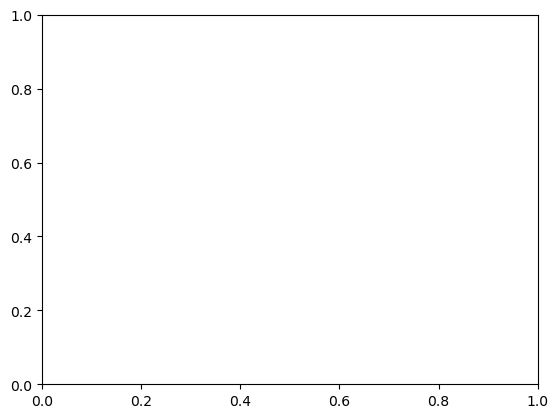

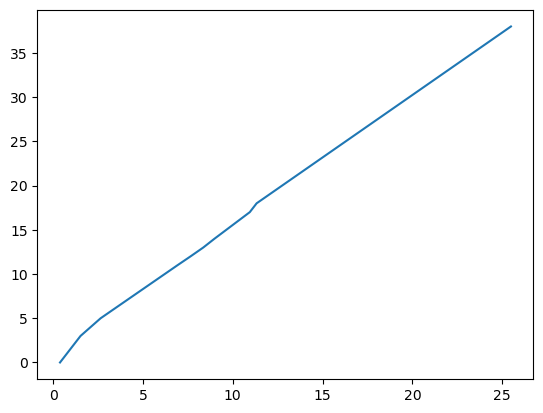

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
f = config["obj"]
best_x = np.array(best_x_list_list_popbo[0])
fig, ax = plt.subplots(1, 1)
ax.plot(np.abs(f(best_x)).cumsum(), list(range(len(best_x))))
plt.show()

In [41]:
best_x_list_list_popbo

[[[3.7125592313907227, 9.775946205504331],
  [3.7125592313907227, 9.775946205504331],
  [3.7125592313907227, 9.775946205504331],
  [3.7125592313907227, 9.775946205504331],
  [-9.86992626884644, -5.4789636976916825],
  [-9.86992626884644, -5.4789636976916825],
  [-9.763563808699878, -9.927900379855021],
  [-9.763563808699878, -9.927900379855021],
  [-9.763563808699878, -9.927900379855021],
  [-9.763563808699878, -9.927900379855021],
  [-9.763563808699878, -9.927900379855021],
  [-9.763563808699878, -9.927900379855021],
  [6.287404308529463, 8.644712547238324],
  [-9.99999862039284, -9.999998669005707],
  [-9.999999, -6.529113661573282],
  [6.997934711834883, 9.999999],
  [6.997934711834883, 9.999999],
  [6.997934711834883, 9.999999],
  [3.7125592313907227, 9.775946205504331],
  [-9.999999, -9.999999],
  [-9.999999, -9.999999],
  [-9.999999, -9.999999],
  [-9.999999, -9.999999],
  [-9.999999, -9.999999],
  [-9.999999, -9.999999],
  [-9.999999, -9.999999],
  [-9.999999, -9.999999],
  [-9.